# Hierarchical Temporal Encoder Training on Google Colab

This notebook trains the **Hierarchical Temporal Encoder** for multi-scale energy system graphs.

## Architecture Overview

```
ENCODER (Bottom-Up)
  Assets (604 nodes)  → Sparse GAT  → Pooling
  Zones (100 nodes)   → Sparse GAT  → Pooling  
  Regions (10 nodes)  → Sparse GAT  → Pooling
  Nation (1 node)     → Temporal Transformer (Dense)

DECODER (Top-Down)
  Nation → Regions → Zones → Assets
  (with skip connections at each level)
```

## Memory Efficiency

- **Sparse GAT** on large graphs (604, 100, 10 nodes)
- **Dense Transformer** only on Nation level (1 node × 96 timesteps)
- **Estimated memory**: 3-8 GB (vs 40+ GB for dense HGT)

## Setup Requirements

- **GPU**: A100 (40GB or 80GB), V100, or T4
- **Runtime**: Python 3.10+
- **Google Drive**: Repository at `/content/drive/MyDrive/benchmark`

## 1. Mount Google Drive

In [1]:
from google.colab import drive
import os
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Set repository path
REPO_PATH = Path('/content/drive/MyDrive/benchmark')

# Change to repository directory
os.chdir(REPO_PATH)

print(f"✅ Google Drive mounted successfully!")
print(f"📁 Repository path: {REPO_PATH}")
print(f"📁 Current directory: {os.getcwd()}")
print(f"\n📂 Repository structure:")
print(f"   - src/ exists: {(REPO_PATH / 'src').exists()}")
print(f"   - outputs/ exists: {(REPO_PATH / 'outputs').exists()}")
print(f"   - outputs/graphs/ exists: {(REPO_PATH / 'outputs' / 'graphs').exists()}")

if not (REPO_PATH / 'src').exists():
    raise RuntimeError(
        f"❌ Repository not found at {REPO_PATH}\n"
        "Please ensure your 'benchmark' folder is in Google Drive at:\n"
        "/content/drive/MyDrive/benchmark"
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📁 Repository path: /content/drive/MyDrive/benchmark
📁 Current directory: /content/drive/MyDrive/benchmark

📂 Repository structure:
   - src/ exists: True
   - outputs/ exists: True
   - outputs/graphs/ exists: True


## 2. Verify GPU

In [2]:
import torch

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("⚠️ WARNING: No GPU detected! Please enable GPU in Runtime > Change runtime type")

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
GPU Device: NVIDIA A100-SXM4-40GB
GPU Memory: 42.47 GB
Number of GPUs: 1


## 3. Install Dependencies

In [3]:
import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q numpy scipy tqdm matplotlib seaborn pandas

print("\n✅ All dependencies installed!")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 118.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 

## 4. Verify Dataset & Extract Hierarchy

In [ ]:
import json
from pathlib import Path
import numpy as np
import torch

# Check dataset
data_dir = REPO_PATH / 'outputs/graphs/hetero_temporal_v1'
index_path = data_dir / 'dataset_index.json'

if not index_path.exists():
    raise FileNotFoundError(f"Dataset index not found at {index_path}")

# Load index
with open(index_path, 'r') as f:
    index_data = json.load(f)

print(f"✅ Dataset found!")
print(f"Total graphs: {len(index_data['entries'])}")

# Load first graph to extract hierarchy
first_graph_rel = index_data['entries'][0]['graph_file'].replace('\\', '/')
first_graph = REPO_PATH / first_graph_rel

if not first_graph.exists():
    raise FileNotFoundError(f"First graph file not found at {first_graph}")

sample = np.load(first_graph, allow_pickle=True)
print(f"\n📊 Sample graph info:")
print(f"  - Node features shape: {sample['node_features'].shape}")
print(f"  - Edge index shape: {sample['edge_index'].shape}")
print(f"  - Node types shape: {sample['node_types'].shape}")

node_feature_dim = sample['node_features'].shape[1]
meta = sample['meta'].item()
N_base = meta['N_base']
T_sample = meta['T']

print(f"\n📊 Dataset Info:")
print(f"  - Node feature dim: {node_feature_dim}")
print(f"  - N_base: {N_base}")
print(f"  - T: {T_sample}")

# Extract node types from base graph (first N_base nodes)
node_types_base = sample['node_types'][:N_base]
unique_types, counts = np.unique(node_types_base, return_counts=True)

print(f"\n🏗️ Node Type Distribution (base graph):")
type_names = {0: "Nation", 1: "Region", 2: "Zone", 3: "Asset", 4: "Weather"}
for nt, count in zip(unique_types, counts):
    print(f"  - Type {nt} ({type_names.get(nt, 'Unknown')}): {count} nodes")

# ===== EXTRACT REAL HIERARCHY FROM GRAPH STRUCTURE =====

# 1. Zone → Region mapping (from zone_region_index in graph)
zone_region_mapping = torch.from_numpy(sample['zone_region_index']).long()
print(f"\n✅ Zone→Region mapping extracted from graph")
print(f"   Shape: {zone_region_mapping.shape}")
print(f"   Unique regions: {zone_region_mapping.unique().tolist()}")

# 2. Asset → Zone mapping (from edges)
# Assets connect to zones via hierarchy edges (edge_type 0-6 are spatial)
edge_index = sample['edge_index']
edge_types = sample['edge_types']
node_types_full = sample['node_types']  # All nodes including temporal

# Find hierarchy edges (types 0-6 are spatial hierarchy edges)
spatial_mask = edge_types < 7
spatial_edges = edge_index[:, spatial_mask]

# Extract base graph edges (within first N_base*T nodes, but map to base)
base_node_mask = spatial_edges[0] < (N_base * T_sample)
base_edges = spatial_edges[:, base_node_mask]

# Map to base node indices (remove temporal dimension)
base_edges_mapped = base_edges % N_base

# Find asset→zone connections
# Assets (type 3) should connect to Zones (type 2)
asset_mask_base = node_types_base == 3
zone_mask_base = node_types_base == 2

# Create asset→zone mapping
num_assets = asset_mask_base.sum().item()
num_zones = zone_mask_base.sum().item()

asset_to_zone = torch.zeros(N_base, dtype=torch.long)
zone_indices = torch.where(zone_mask_base)[0]

# For each asset, find its parent zone via edges
for asset_idx in torch.where(asset_mask_base)[0]:
    # Find edges where this asset is the source
    outgoing_mask = base_edges_mapped[0] == asset_idx
    if outgoing_mask.any():
        targets = base_edges_mapped[1, outgoing_mask]
        # Find which targets are zones
        zone_targets = targets[zone_mask_base[targets]]
        if len(zone_targets) > 0:
            # Map to zone list index (0 to num_zones-1)
            zone_node_id = zone_targets[0].item()
            zone_list_idx = (zone_indices == zone_node_id).nonzero(as_tuple=True)[0]
            if len(zone_list_idx) > 0:
                asset_to_zone[asset_idx] = zone_list_idx[0]

# For non-asset nodes, assign to first zone (fallback)
asset_to_zone[~asset_mask_base] = 0

print(f"\n✅ Asset→Zone mapping extracted from edges")
print(f"   Shape: {asset_to_zone.shape}")
print(f"   Assets mapped to {asset_to_zone[asset_mask_base].unique().numel()} unique zones")

# Create final hierarchy mapping
hierarchy_mapping = {
    'asset_to_zone': asset_to_zone,
    'zone_to_region': zone_region_mapping,
}

print(f"\n✅ Hierarchy mappings created!")
print(f"  - asset_to_zone shape: {asset_to_zone.shape}")
print(f"  - zone_to_region shape: {zone_region_mapping.shape}")
print(f"  - Regions: {zone_region_mapping.unique().tolist()}")

✅ Dataset found!
Total graphs: 2000

Sample graph info:
  - Node features shape: (57984, 14)
  - Edge index shape: (2, 63769)
  - Node types shape: (57984,)
  - Metadata: {'N_base': 604, 'T': 96, 'temporal_edges': ['soc', 'ramp', 'dr'], 'time_encoding': 'sinusoidal', 'target_horizon': 0, 'schema_version': '2.0-temporal'}

📊 Dataset Info:
  - Node feature dim: 14
  - N_base: 604
  - T: 96

🏗️ Node Type Distribution (base graph):
  - Type 0: 1 nodes
  - Type 1: 12 nodes
  - Type 2: 89 nodes
  - Type 3: 490 nodes
  - Type 4: 12 nodes

🔗 Creating hierarchy mappings...
  - Assets: 502
  - Zones: 89
  - Regions: 12

✅ Hierarchy mappings created!
  - asset_to_zone shape: torch.Size([604])
  - zone_to_region shape: torch.Size([89])


## 5. Configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    """Training configuration for Hierarchical Temporal Encoder"""

    # Data (Google Drive paths)
    repo_path: str = '/content/drive/MyDrive/benchmark'
    data_dir: str = '/content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1'
    train_split: float = 0.8

    # Model architecture - OPTIMIZED for 604 nodes
    hidden_dim: int = 128           # Rich embeddings
    num_spatial_layers: int = 2     # 2 layers per hierarchy level
    num_temporal_layers: int = 4    # Dense temporal at top
    num_heads: int = 8              # Multi-head attention
    dropout: float = 0.1

    # Training
    loss_type: str = 'multilag'
    epochs: int = 150
    batch_size: int = 1             # 1 graph at a time
    lr: float = 3e-4
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    warmup_epochs: int = 10

    # Loss hyperparams (for contrastive learning)
    max_nodes: int = 512            # Subsample nodes in loss if needed
    neg_sample_ratio: float = 0.1   # Ratio of negatives to sample
    temperature: float = 0.07

    # Output (Google Drive paths)
    save_dir: str = '/content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal'
    save_embeddings: bool = True
    save_freq: int = 10

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers: int = 0

config = TrainingConfig()

print("📋 Training Configuration:")
print(f"  Repo path: {config.repo_path}")
print(f"  Model: Hierarchical Temporal Encoder")
print(f"  Hidden dim: {config.hidden_dim}")
print(f"  Spatial layers: {config.num_spatial_layers} (per level)")
print(f"  Temporal layers: {config.num_temporal_layers} (at Nation level)")
print(f"  Attention heads: {config.num_heads}")
print(f"  Batch size: {config.batch_size}")
print(f"  Device: {config.device}")
print(f"  Save directory: {config.save_dir}")
print(f"\n💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)")

📋 Training Configuration:
  Repo path: /content/drive/MyDrive/benchmark
  Model: Hierarchical Temporal Encoder
  Hidden dim: 128
  Spatial layers: 2 (per level)
  Temporal layers: 4 (at Nation level)
  Attention heads: 8
  Batch size: 1
  Device: cuda
  Save directory: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal

💾 Estimated memory: ~5-8 GB (vs 40+ GB for dense HGT)


In [ ]:
import torch

def get_hierarchy_from_batch(batch, device):
    """
    Returns a dict with:
      - asset_to_zone: LongTensor [N_assets]
      - zone_to_region: LongTensor [N_zones]
    Priority:
      1) direct attributes on batch (recommended)
      2) packed hierarchy_mapping on batch
      3) raise a clear error (better than silent wrong mapping)
    """
    # Case 1: explicit tensors on batch
    if hasattr(batch, "asset_to_zone") and hasattr(batch, "zone_to_region"):
        return {
            "asset_to_zone": batch.asset_to_zone.to(device),
            "zone_to_region": batch.zone_to_region.to(device),
        }

    # Case 2: packed mapping
    if hasattr(batch, "hierarchy_mapping") and batch.hierarchy_mapping is not None:
        hm = batch.hierarchy_mapping
        return {
            "asset_to_zone": hm["asset_to_zone"].to(device),
            "zone_to_region": hm["zone_to_region"].to(device),
        }

    # If you reach here, don't do modulo hacks — fail loudly
    raise RuntimeError(
        "❌ No hierarchy mapping found in batch. "
        "Please store asset_to_zone and zone_to_region in each graph object during dataset creation."
    )


## 6. Load Model & Create Dataset

In [ ]:
import sys
from pathlib import Path
import json
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Set seed
SEED = 42

# Add repo path to sys.path (Google Drive)
REPO_ROOT = Path('/content/drive/MyDrive/benchmark')
sys.path.insert(0, str(REPO_ROOT))

print(f"📦 Adding to sys.path: {REPO_ROOT}")

# Import model and dataset
from src.gnn.models.hierarchical_temporal_encoder import HierarchicalTemporalEncoder
from src.gnn.models.temporal_hetero_gnn import TemporalGraphDataset

print("✅ Model imported successfully!")

# Load dataset
print("\nLoading dataset...")
data_dir = Path(config.data_dir)
index_path = data_dir / "dataset_index.json"

with open(index_path, 'r') as f:
    index_data = json.load(f)

# Build graph file paths
graph_files = []
for e in index_data["entries"]:
    rel_path = e["graph_file"].replace('\\', '/')
    graph_files.append(REPO_ROOT / rel_path)

print(f"Found {len(graph_files)} graphs")

# Create dataset
dataset = TemporalGraphDataset(graph_files, target_indices=None)

g = torch.Generator().manual_seed(SEED)

train_size = int(config.train_split * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=g)

# Sauvegarde des indices réels (super utile pour reproduire + paper)
split_path = Path(config.data_dir) / f"split_seed{SEED}_train{train_size}_val{val_size}.json"
split_payload = {
    "seed": SEED,
    "train_size": train_size,
    "val_size": val_size,
    "train_indices": train_dataset.indices,
    "val_indices": val_dataset.indices,
}
split_path.write_text(json.dumps(split_payload, indent=2))
print(f"✅ Split saved to: {split_path}")


# Create loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

📦 Adding to sys.path: /content/drive/MyDrive/benchmark
✅ Model imported successfully!

Loading dataset...
Found 2000 graphs
Train: 1600, Val: 400
Train batches: 1600
Val batches: 400


## 7. Create Model

In [6]:
import gc

# Create model
print("🔨 Creating Hierarchical Temporal Encoder...")

model = HierarchicalTemporalEncoder(
    node_feature_dim=node_feature_dim,
    hidden_dim=config.hidden_dim,
    num_spatial_layers=config.num_spatial_layers,
    num_temporal_layers=config.num_temporal_layers,
    num_heads=config.num_heads,
    dropout=config.dropout,
)

model = model.to(config.device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.2f} MB (FP32)")

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
    betas=(0.9, 0.999),
)

print(f"\n✅ Optimizer: AdamW")
print(f"   Learning rate: {config.lr}")
print(f"   Weight decay: {config.weight_decay}")

# Create scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_epochs, num_epochs):
    """Cosine annealing with linear warmup"""
    def lr_lambda(epoch):
        if epoch < num_warmup_epochs:
            return float(epoch) / float(max(1, num_warmup_epochs))
        progress = float(epoch - num_warmup_epochs) / float(max(1, num_epochs - num_warmup_epochs))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

import math
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_epochs=config.warmup_epochs,
    num_epochs=config.epochs
)

print(f"\n✅ Scheduler: Cosine Annealing with Warmup")
print(f"   Warmup epochs: {config.warmup_epochs}")
print(f"   Total epochs: {config.epochs}")

# Memory info
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()
    print(f"\n💾 GPU Memory:")
    print(f"   Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    print(f"   Free: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved(0)) / 1e9:.2f} GB")

🔨 Creating Hierarchical Temporal Encoder...
✅ Model created!
   Total parameters: 3,185,664
   Trainable parameters: 3,185,664
   Model size: ~12.74 MB (FP32)

✅ Optimizer: AdamW
   Learning rate: 0.0003
   Weight decay: 1e-05

✅ Scheduler: Cosine Annealing with Warmup
   Warmup epochs: 10
   Total epochs: 150

💾 GPU Memory:
   Allocated: 0.01 GB
   Reserved: 0.01 GB
   Free: 42.46 GB


## 8. Loss Functions

In [ ]:
import torch.nn.functional as F
import torch

import torch
import torch.nn.functional as F

def contrastive_loss_multilag(
    embeddings,
    lags=(1, 4, 8),
    neg_sample_ratio=0.25,
    max_nodes=160,
    temperature=0.10
):
    """
    embeddings: either
      - Tensor [N, T, D]  (asset-level sequence)
      - dict with embeddings['assets'] = [N, T, D]
    """
    if isinstance(embeddings, dict):
        embeddings = embeddings["assets"]

    N, T, D = embeddings.shape
    device = embeddings.device

    # Subsample nodes (stability + speed)
    if N > max_nodes:
        idx = torch.randperm(N, device=device)[:max_nodes]
        embeddings = embeddings[idx]
        N = max_nodes

    # Normalize
    emb = F.normalize(embeddings, dim=-1)  # [N, T, D]

    # Build anchors and positives for multiple lags
    anchor_list = []
    pos_list = []
    for lag in lags:
        if lag >= T:
            continue
        # anchors: [:, 0:T-lag], positives: [:, lag:T]
        a = emb[:, :T-lag, :].reshape(-1, D)   # [N*(T-lag), D]
        p = emb[:, lag:, :].reshape(-1, D)
        anchor_list.append(a)
        pos_list.append(p)

    anchors = torch.cat(anchor_list, dim=0)  # [M, D]
    positives = torch.cat(pos_list, dim=0)   # [M, D]
    M = anchors.size(0)

    # Build negatives by sampling from all (node,time) embeddings
    flat = emb.reshape(N*T, D)  # [N*T, D]
    n_neg = max(128, int(M * neg_sample_ratio))

    neg_idx = torch.randint(0, N*T, (n_neg,), device=device)
    negatives = flat[neg_idx]  # [n_neg, D]

    # InfoNCE: logits = [pos | negs]
    pos_logits = (anchors * positives).sum(dim=-1, keepdim=True) / temperature  # [M,1]
    neg_logits = anchors @ negatives.t() / temperature                          # [M,n_neg]
    logits = torch.cat([pos_logits, neg_logits], dim=1)                         # [M,1+n_neg]

    labels = torch.zeros(M, dtype=torch.long, device=device)  # positive is at index 0
    return F.cross_entropy(logits, labels)


def contrastive_loss_optimized(embeddings, temperature=0.07, max_nodes=512, neg_sample_ratio=0.1):
    """
    Memory-efficient InfoNCE contrastive loss.

    Strategy:
    1. Subsample nodes if N > max_nodes
    2. Sample negatives instead of computing full similarity matrix
    3. Process in chunks to reduce memory

    Args:
        embeddings: [N, T, D] tensor or dict with 'assets' key
        temperature: Softmax temperature
        max_nodes: Maximum nodes to use (subsample if more)
        neg_sample_ratio: Ratio of negatives to sample
    """
    # Handle dict input (from hierarchical encoder)
    if isinstance(embeddings, dict):
        embeddings = embeddings['assets']  # Use asset-level embeddings

    N, T, D = embeddings.shape
    device = embeddings.device

    # Subsample nodes if necessary
    if N > max_nodes:
        perm = torch.randperm(N, device=device)[:max_nodes]
        embeddings = embeddings[perm]
        N = max_nodes

    # Flatten and normalize
    flat = embeddings.view(N * T, D)
    flat = F.normalize(flat, dim=1)

    total_nodes = N * T
    max_negatives = max(100, int(total_nodes * neg_sample_ratio))

    # Create positive pairs (adjacent timesteps)
    node_ids = torch.arange(N, device=device).repeat_interleave(T - 1)
    time_ids = torch.arange(T - 1, device=device).repeat(N)
    anchor_indices = node_ids * T + time_ids
    positive_indices = node_ids * T + (time_ids + 1)

    # Process in chunks
    chunk_size = 256
    num_pairs = anchor_indices.size(0)
    total_loss = 0.0

    for chunk_start in range(0, num_pairs, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_pairs)
        chunk_anchors = anchor_indices[chunk_start:chunk_end]
        chunk_positives = positive_indices[chunk_start:chunk_end]

        # Get embeddings
        anchor_embs = flat[chunk_anchors]
        positive_embs = flat[chunk_positives]

        # Positive similarities
        pos_sims = (anchor_embs * positive_embs).sum(dim=1, keepdim=True) / temperature

        # Sample negatives
        neg_indices = torch.randperm(total_nodes, device=device)[:max_negatives]
        neg_embs = flat[neg_indices]

        # Negative similarities
        neg_sims = torch.matmul(anchor_embs, neg_embs.t()) / temperature

        # Combine
        all_sims = torch.cat([pos_sims, neg_sims], dim=1)

        # Loss
        chunk_loss = -F.log_softmax(all_sims, dim=1)[:, 0].mean()
        total_loss += chunk_loss * (chunk_end - chunk_start)

    return total_loss / num_pairs


def multi_scale_contrastive_loss(
    embeddings_dict,
    temperature=0.07,
    weights={'assets': 1.0, 'zones': 0.3, 'regions': 0.1}
):
    """
    Multi-scale contrastive loss across hierarchy levels.

    Computes contrastive loss at multiple scales and combines them.
    This encourages the model to learn good representations at all levels.
    """
    total_loss = 0.0

    for level, weight in weights.items():
        if level in embeddings_dict and weight > 0:
            level_loss = contrastive_loss_optimized(
                embeddings_dict[level],
                temperature=temperature,
                max_nodes=512,
                neg_sample_ratio=0.1
            )
            total_loss += weight * level_loss

    return total_loss


print("✅ Loss functions defined:")
print("   - contrastive_loss_optimized: Memory-efficient InfoNCE")
print("   - multi_scale_contrastive_loss: Hierarchical loss across levels")

✅ Loss functions defined:
   - contrastive_loss_optimized: Memory-efficient InfoNCE
   - multi_scale_contrastive_loss: Hierarchical loss across levels


## 9. Training Loop

In [ ]:
from tqdm.notebook import tqdm
import time
import torch
from torch.utils.checkpoint import checkpoint
from torch_geometric.utils import add_self_loops

def train_epoch(model, loader, optimizer, device, accumulation_steps=4):
    model.train()
    total_loss = 0.0
    num_batches = 0

    optimizer.zero_grad(set_to_none=True)

    pbar = tqdm(loader, desc="Training", leave=False)
    for i, batch in enumerate(pbar):
        batch = batch.to(device)

        # Robust node count
        # If batch.x is [num_nodes, feat_dim]
        N_total = batch.x.size(0) if hasattr(batch, "x") and batch.x is not None else batch.num_nodes

        # Your N_base and T logic (keep your own if correct)
        N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()

        # ✅ Always use real hierarchy from batch
        current_hierarchy = get_hierarchy_from_batch(batch, device)

        # Self-loops: use N_total if your edge_index spans all nodes
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=N_total)

        with torch.autocast(device_type="cuda", enabled=torch.cuda.is_available()):
            embeddings = model(
                batch.x,
                edge_index_with_loops,
                batch.node_type if hasattr(batch, "node_type") else None,
                N_base,
                T,
                hierarchy_mapping=current_hierarchy,
                zone_edges=None,
                region_edges=None,
                batch=None,
                return_sequence=True,
            )

            loss = contrastive_loss_multilag(
                embeddings,
                lags=(1, 4, 8),
                neg_sample_ratio=0.25,
                max_nodes=160,   # tune
                temperature=0.10
            )

            loss = loss / accumulation_steps

        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * accumulation_steps
        num_batches += 1
        pbar.set_postfix(loss=f"{total_loss/num_batches:.4f}")

    # ✅ Final optimizer step if we ended mid-accumulation
    remainder = (i + 1) % accumulation_steps
    if remainder != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

    return total_loss / max(1, num_batches)

@torch.no_grad()
def validate_epoch(model, loader, device, loss_type):
    """
    Validate the model on the validation set.
    """
    model.eval()
    total_loss = 0.0
    num_batches = 0

    for batch in loader:
        batch = batch.to(device)

        # Get N_base and T
        if hasattr(batch, 'N_base'):
            N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        else:
            continue

        if hasattr(batch, 'T'):
            T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()
        else:
            continue

        # Dynamic Hierarchy Mapping
        # ✅ Always use real hierarchy from the batch (never modulo hacks)
        current_hierarchy = get_hierarchy_from_batch(batch, device)

        # Add self-loops
        num_nodes = batch.x.size(0)
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=num_nodes)


        # Forward (Inference mode, no checkpointing needed)
        with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16, enabled=torch.cuda.is_available()):
            out = model(
                batch.x,
                edge_index_with_loops,
                batch.node_type,
                N_base, T,
                current_hierarchy,
                zone_edges=None,
                region_edges=None,
                batch=None,
                return_sequence=True,
            )
            # model returns dict directly
            embeddings = out

        # Compute loss
        if loss_type == "contrastive":
            embeddings_f32 = {k: v.float() for k, v in embeddings.items() if k in ['assets', 'zones', 'regions', 'nation']}
            loss = contrastive_loss_optimized(
                embeddings_f32,
                temperature=0.07,
                max_nodes=512,
                neg_sample_ratio=0.1
            )
        elif loss_type == "multi_scale":
            embeddings_f32 = {k: v.float() for k, v in embeddings.items() if k in ['assets', 'zones', 'regions', 'nation']}
            loss = multi_scale_contrastive_loss(
                embeddings_f32,
                temperature=0.07,
                weights={'assets': 1.0, 'zones': 0.3, 'regions': 0.1}
            )
        elif loss_type == "multilag":
            embeddings_f32 = {k: v.float() for k, v in embeddings.items() if k in ['assets', 'zones', 'regions', 'nation']}
            loss = contrastive_loss_multilag(
                embeddings_f32,
                lags=(1, 4, 8),
                neg_sample_ratio=0.25,
                max_nodes=160,   # tune
                temperature=0.10
            )
        else:
            raise ValueError(f"Unknown loss type: {loss_type}")

        total_loss += loss.item()
        num_batches += 1

    return total_loss / max(num_batches, 1)

print("✅ Training & Validation loops ready")
print("   - Gradient Accumulation (Training)")
print("   - Early Stopping Support (Validation)")

✅ Training & Validation loops ready
   - Gradient Accumulation (Training)
   - Early Stopping Support (Validation)


In [ ]:
batch0 = next(iter(train_loader)).to(config.device)
h = get_hierarchy_from_batch(batch0, config.device)
print("✅ hierarchy keys:", h.keys())
print("asset_to_zone:", h["asset_to_zone"].shape, h["asset_to_zone"].dtype)
print("zone_to_region:", h["zone_to_region"].shape, h["zone_to_region"].dtype)
print("batch.x:", batch0.x.shape)


## 10. Train Model

In [9]:
import os
import gc

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create save directory
save_dir = Path(config.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# Clear GPU cache
print("🧹 Clearing GPU cache...")
torch.cuda.empty_cache()
gc.collect()

🧹 Clearing GPU cache...


0

In [ ]:
import os
import gc

# Memory optimization
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Create save directory
save_dir = Path(config.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# Clear GPU cache
print("🧹 Clearing GPU cache...")
torch.cuda.empty_cache()
gc.collect()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'lr': [],
    'epoch_time': []
}

best_val_loss = float('inf')
patience_counter = 0
EARLY_STOPPING_PATIENCE = 10  # Stop if val_loss doesn't improve for 10 epochs

# Gradient Accumulation Settings
ACCUMULATION_STEPS = 8
EFFECTIVE_BATCH_SIZE = config.batch_size * ACCUMULATION_STEPS

print(f"\n🚀 Starting training for {config.epochs} epochs...")
print(f"   - Early Stopping Patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"   - Gradient Accumulation: {ACCUMULATION_STEPS} steps")
print(f"   - Effective Batch Size: {EFFECTIVE_BATCH_SIZE}")

for epoch in range(1, config.epochs + 1):
    start_time = time.time()

    # --- TRAIN ---
    train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        config.device,
        config.loss_type,
        accumulation_steps=ACCUMULATION_STEPS
    )

    # --- VALIDATE ---
    val_loss = validate_epoch(
        model,
        val_loader,
        config.device,
        config.loss_type
    )

    # Update scheduler
    scheduler.step()

    # Record history
    epoch_time = time.time() - start_time
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    history['epoch_time'].append(epoch_time)

    # Print progress
    print(f"Epoch {epoch:3d}/{config.epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {epoch_time:.2f}s")

    # --- EARLY STOPPING & CHECKPOINTING ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss,
            'config': config,
            'hierarchy_mapping': hierarchy_mapping,
        }, save_dir / "best_encoder.pt")
        print(f"  💾 Saved BEST model (val_loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏳ No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs.")
        break

    # Save regular checkpoint
    if epoch % config.save_freq == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss,
            'history': history,
            'config': config,
        }, save_dir / f"checkpoint_epoch_{epoch}.pt")

print(f"\n✅ Training complete!")
print(f"Best Val Loss: {best_val_loss:.6f}")
print(f"Model saved to: {save_dir}")

🧹 Clearing GPU cache...

🚀 Starting training for 150 epochs...
   - Early Stopping Patience: 10 epochs
   - Gradient Accumulation: 8 steps
   - Effective Batch Size: 8


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   1/150 | Train Loss: 12.3127 | Val Loss: 12.3973 | LR: 0.000030 | Time: 1633.74s
  💾 Saved BEST model (val_loss: 12.3973)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   2/150 | Train Loss: 8.1135 | Val Loss: 7.4224 | LR: 0.000060 | Time: 833.98s
  💾 Saved BEST model (val_loss: 7.4224)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   3/150 | Train Loss: 7.4518 | Val Loss: 7.3789 | LR: 0.000090 | Time: 834.78s
  💾 Saved BEST model (val_loss: 7.3789)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   4/150 | Train Loss: 7.3826 | Val Loss: 7.2550 | LR: 0.000120 | Time: 833.52s
  💾 Saved BEST model (val_loss: 7.2550)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   5/150 | Train Loss: 7.2350 | Val Loss: 7.1428 | LR: 0.000150 | Time: 854.09s
  💾 Saved BEST model (val_loss: 7.1428)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   6/150 | Train Loss: 7.1540 | Val Loss: 7.0638 | LR: 0.000180 | Time: 851.37s
  💾 Saved BEST model (val_loss: 7.0638)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   7/150 | Train Loss: 7.0960 | Val Loss: 7.0307 | LR: 0.000210 | Time: 850.86s
  💾 Saved BEST model (val_loss: 7.0307)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   8/150 | Train Loss: 7.0417 | Val Loss: 6.9567 | LR: 0.000240 | Time: 854.11s
  💾 Saved BEST model (val_loss: 6.9567)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch   9/150 | Train Loss: 6.9147 | Val Loss: 6.7712 | LR: 0.000270 | Time: 844.61s
  💾 Saved BEST model (val_loss: 6.7712)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  10/150 | Train Loss: 6.7343 | Val Loss: 6.5806 | LR: 0.000300 | Time: 829.75s
  💾 Saved BEST model (val_loss: 6.5806)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  11/150 | Train Loss: 6.6030 | Val Loss: 6.5176 | LR: 0.000300 | Time: 822.91s
  💾 Saved BEST model (val_loss: 6.5176)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  12/150 | Train Loss: 6.5395 | Val Loss: 6.5015 | LR: 0.000300 | Time: 821.08s
  💾 Saved BEST model (val_loss: 6.5015)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  13/150 | Train Loss: 6.4769 | Val Loss: 6.4428 | LR: 0.000300 | Time: 823.79s
  💾 Saved BEST model (val_loss: 6.4428)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  14/150 | Train Loss: 6.4456 | Val Loss: 6.4072 | LR: 0.000299 | Time: 826.16s
  💾 Saved BEST model (val_loss: 6.4072)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  15/150 | Train Loss: 6.4251 | Val Loss: 6.3301 | LR: 0.000299 | Time: 826.73s
  💾 Saved BEST model (val_loss: 6.3301)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  16/150 | Train Loss: 6.3750 | Val Loss: 6.3429 | LR: 0.000299 | Time: 826.61s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  17/150 | Train Loss: 6.3719 | Val Loss: 6.3335 | LR: 0.000298 | Time: 824.21s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  18/150 | Train Loss: 6.3512 | Val Loss: 6.3357 | LR: 0.000298 | Time: 826.18s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  19/150 | Train Loss: 6.3392 | Val Loss: 6.2946 | LR: 0.000297 | Time: 822.01s
  💾 Saved BEST model (val_loss: 6.2946)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  20/150 | Train Loss: 6.3217 | Val Loss: 6.2404 | LR: 0.000296 | Time: 824.96s
  💾 Saved BEST model (val_loss: 6.2404)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  21/150 | Train Loss: 6.2958 | Val Loss: 6.2456 | LR: 0.000295 | Time: 846.14s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  22/150 | Train Loss: 6.2848 | Val Loss: 6.2235 | LR: 0.000295 | Time: 819.49s
  💾 Saved BEST model (val_loss: 6.2235)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  23/150 | Train Loss: 6.2665 | Val Loss: 6.2206 | LR: 0.000294 | Time: 821.61s
  💾 Saved BEST model (val_loss: 6.2206)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  24/150 | Train Loss: 6.2488 | Val Loss: 6.1795 | LR: 0.000293 | Time: 820.30s
  💾 Saved BEST model (val_loss: 6.1795)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  25/150 | Train Loss: 6.2118 | Val Loss: 6.1360 | LR: 0.000292 | Time: 821.79s
  💾 Saved BEST model (val_loss: 6.1360)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  26/150 | Train Loss: 6.1647 | Val Loss: 6.0549 | LR: 0.000290 | Time: 820.38s
  💾 Saved BEST model (val_loss: 6.0549)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  27/150 | Train Loss: 6.0690 | Val Loss: 5.9466 | LR: 0.000289 | Time: 821.89s
  💾 Saved BEST model (val_loss: 5.9466)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  28/150 | Train Loss: 5.9212 | Val Loss: 5.7513 | LR: 0.000288 | Time: 821.57s
  💾 Saved BEST model (val_loss: 5.7513)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  29/150 | Train Loss: 5.7485 | Val Loss: 5.5263 | LR: 0.000287 | Time: 820.30s
  💾 Saved BEST model (val_loss: 5.5263)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  30/150 | Train Loss: 5.6379 | Val Loss: 5.3345 | LR: 0.000285 | Time: 821.39s
  💾 Saved BEST model (val_loss: 5.3345)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  31/150 | Train Loss: 5.4551 | Val Loss: 5.3504 | LR: 0.000284 | Time: 820.10s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  32/150 | Train Loss: 5.4787 | Val Loss: 5.5595 | LR: 0.000282 | Time: 842.27s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  33/150 | Train Loss: 5.3986 | Val Loss: 5.1932 | LR: 0.000280 | Time: 822.61s
  💾 Saved BEST model (val_loss: 5.1932)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  34/150 | Train Loss: 5.3484 | Val Loss: 5.3096 | LR: 0.000279 | Time: 821.18s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  35/150 | Train Loss: 5.4122 | Val Loss: 5.1466 | LR: 0.000277 | Time: 820.95s
  💾 Saved BEST model (val_loss: 5.1466)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  36/150 | Train Loss: 5.2785 | Val Loss: 5.1583 | LR: 0.000275 | Time: 823.98s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  37/150 | Train Loss: 5.2536 | Val Loss: 5.2305 | LR: 0.000273 | Time: 843.86s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  38/150 | Train Loss: 5.1891 | Val Loss: 5.0166 | LR: 0.000271 | Time: 820.94s
  💾 Saved BEST model (val_loss: 5.0166)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  39/150 | Train Loss: 5.1951 | Val Loss: 4.9724 | LR: 0.000269 | Time: 820.84s
  💾 Saved BEST model (val_loss: 4.9724)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  40/150 | Train Loss: 5.1532 | Val Loss: 4.9570 | LR: 0.000267 | Time: 820.67s
  💾 Saved BEST model (val_loss: 4.9570)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  41/150 | Train Loss: 5.1536 | Val Loss: 5.4399 | LR: 0.000265 | Time: 819.20s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  42/150 | Train Loss: 5.1143 | Val Loss: 5.1666 | LR: 0.000263 | Time: 820.27s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  43/150 | Train Loss: 5.0533 | Val Loss: 4.9396 | LR: 0.000261 | Time: 819.84s
  💾 Saved BEST model (val_loss: 4.9396)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  44/150 | Train Loss: 5.0893 | Val Loss: 5.0275 | LR: 0.000258 | Time: 822.51s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  45/150 | Train Loss: 5.1143 | Val Loss: 5.1575 | LR: 0.000256 | Time: 819.49s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  46/150 | Train Loss: 5.0722 | Val Loss: 4.9933 | LR: 0.000254 | Time: 819.90s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  47/150 | Train Loss: 5.0646 | Val Loss: 4.8942 | LR: 0.000251 | Time: 819.73s
  💾 Saved BEST model (val_loss: 4.8942)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  48/150 | Train Loss: 5.0161 | Val Loss: 4.8998 | LR: 0.000249 | Time: 821.45s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  49/150 | Train Loss: 5.0035 | Val Loss: 5.1295 | LR: 0.000246 | Time: 824.85s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  50/150 | Train Loss: 5.0586 | Val Loss: 4.9015 | LR: 0.000244 | Time: 822.62s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  51/150 | Train Loss: 4.9050 | Val Loss: 4.6672 | LR: 0.000241 | Time: 819.14s
  💾 Saved BEST model (val_loss: 4.6672)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  52/150 | Train Loss: 4.9234 | Val Loss: 4.7970 | LR: 0.000238 | Time: 829.35s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  53/150 | Train Loss: 4.9066 | Val Loss: 4.8741 | LR: 0.000235 | Time: 821.09s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  54/150 | Train Loss: 4.8487 | Val Loss: 4.8371 | LR: 0.000233 | Time: 823.24s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  55/150 | Train Loss: 4.8817 | Val Loss: 4.6647 | LR: 0.000230 | Time: 819.21s
  💾 Saved BEST model (val_loss: 4.6647)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  56/150 | Train Loss: 4.8843 | Val Loss: 4.6595 | LR: 0.000227 | Time: 843.93s
  💾 Saved BEST model (val_loss: 4.6595)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  57/150 | Train Loss: 4.8826 | Val Loss: 4.5687 | LR: 0.000224 | Time: 833.92s
  💾 Saved BEST model (val_loss: 4.5687)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  58/150 | Train Loss: 4.8444 | Val Loss: 4.7682 | LR: 0.000221 | Time: 837.87s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  59/150 | Train Loss: 4.7707 | Val Loss: 4.6196 | LR: 0.000218 | Time: 835.11s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  60/150 | Train Loss: 4.6932 | Val Loss: 4.5696 | LR: 0.000215 | Time: 829.09s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  61/150 | Train Loss: 4.6392 | Val Loss: 4.5436 | LR: 0.000212 | Time: 830.56s
  💾 Saved BEST model (val_loss: 4.5436)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  62/150 | Train Loss: 4.6222 | Val Loss: 4.3786 | LR: 0.000209 | Time: 823.54s
  💾 Saved BEST model (val_loss: 4.3786)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  63/150 | Train Loss: 4.5373 | Val Loss: 4.2983 | LR: 0.000206 | Time: 820.92s
  💾 Saved BEST model (val_loss: 4.2983)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  64/150 | Train Loss: 4.5071 | Val Loss: 4.4671 | LR: 0.000203 | Time: 821.36s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  65/150 | Train Loss: 4.4679 | Val Loss: 4.2561 | LR: 0.000200 | Time: 821.48s
  💾 Saved BEST model (val_loss: 4.2561)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  66/150 | Train Loss: 4.3914 | Val Loss: 4.1940 | LR: 0.000196 | Time: 826.50s
  💾 Saved BEST model (val_loss: 4.1940)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  67/150 | Train Loss: 4.3703 | Val Loss: 4.3161 | LR: 0.000193 | Time: 822.64s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  68/150 | Train Loss: 4.3442 | Val Loss: 4.2112 | LR: 0.000190 | Time: 821.49s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  69/150 | Train Loss: 4.3302 | Val Loss: 4.2830 | LR: 0.000187 | Time: 821.10s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  70/150 | Train Loss: 4.2984 | Val Loss: 4.1853 | LR: 0.000183 | Time: 822.67s
  💾 Saved BEST model (val_loss: 4.1853)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  71/150 | Train Loss: 4.3079 | Val Loss: 4.1193 | LR: 0.000180 | Time: 821.61s
  💾 Saved BEST model (val_loss: 4.1193)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  72/150 | Train Loss: 4.2268 | Val Loss: 4.1860 | LR: 0.000177 | Time: 821.01s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  73/150 | Train Loss: 4.2045 | Val Loss: 3.9770 | LR: 0.000173 | Time: 820.22s
  💾 Saved BEST model (val_loss: 3.9770)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  74/150 | Train Loss: 4.1780 | Val Loss: 4.0402 | LR: 0.000170 | Time: 821.68s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  75/150 | Train Loss: 4.1658 | Val Loss: 3.9878 | LR: 0.000167 | Time: 821.62s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  76/150 | Train Loss: 4.1240 | Val Loss: 4.1682 | LR: 0.000163 | Time: 820.11s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  77/150 | Train Loss: 4.1114 | Val Loss: 3.9835 | LR: 0.000160 | Time: 820.81s
  ⏳ No improvement (4/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  78/150 | Train Loss: 4.0906 | Val Loss: 4.0135 | LR: 0.000157 | Time: 820.64s
  ⏳ No improvement (5/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  79/150 | Train Loss: 4.0807 | Val Loss: 4.0202 | LR: 0.000153 | Time: 819.38s
  ⏳ No improvement (6/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  80/150 | Train Loss: 4.0725 | Val Loss: 4.0054 | LR: 0.000150 | Time: 820.56s
  ⏳ No improvement (7/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  81/150 | Train Loss: 4.0640 | Val Loss: 3.9686 | LR: 0.000147 | Time: 821.23s
  💾 Saved BEST model (val_loss: 3.9686)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  82/150 | Train Loss: 4.0651 | Val Loss: 4.0437 | LR: 0.000143 | Time: 821.33s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  83/150 | Train Loss: 4.0217 | Val Loss: 3.9918 | LR: 0.000140 | Time: 820.81s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  84/150 | Train Loss: 4.0014 | Val Loss: 3.9954 | LR: 0.000137 | Time: 820.96s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  85/150 | Train Loss: 4.0166 | Val Loss: 3.9548 | LR: 0.000133 | Time: 821.91s
  💾 Saved BEST model (val_loss: 3.9548)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  86/150 | Train Loss: 3.9754 | Val Loss: 3.8811 | LR: 0.000130 | Time: 821.50s
  💾 Saved BEST model (val_loss: 3.8811)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  87/150 | Train Loss: 3.9575 | Val Loss: 3.9763 | LR: 0.000127 | Time: 823.00s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  88/150 | Train Loss: 3.9423 | Val Loss: 3.8613 | LR: 0.000123 | Time: 820.98s
  💾 Saved BEST model (val_loss: 3.8613)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  89/150 | Train Loss: 3.9260 | Val Loss: 3.7632 | LR: 0.000120 | Time: 820.41s
  💾 Saved BEST model (val_loss: 3.7632)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  90/150 | Train Loss: 3.8958 | Val Loss: 4.0037 | LR: 0.000117 | Time: 821.64s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  91/150 | Train Loss: 3.8957 | Val Loss: 3.7611 | LR: 0.000113 | Time: 819.95s
  💾 Saved BEST model (val_loss: 3.7611)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  92/150 | Train Loss: 3.8777 | Val Loss: 3.7904 | LR: 0.000110 | Time: 820.73s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  93/150 | Train Loss: 3.8571 | Val Loss: 3.7159 | LR: 0.000107 | Time: 821.75s
  💾 Saved BEST model (val_loss: 3.7159)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  94/150 | Train Loss: 3.8522 | Val Loss: 3.8912 | LR: 0.000104 | Time: 823.39s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  95/150 | Train Loss: 3.8356 | Val Loss: 3.7100 | LR: 0.000100 | Time: 824.51s
  💾 Saved BEST model (val_loss: 3.7100)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  96/150 | Train Loss: 3.8156 | Val Loss: 3.7178 | LR: 0.000097 | Time: 822.74s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  97/150 | Train Loss: 3.8282 | Val Loss: 3.9322 | LR: 0.000094 | Time: 820.00s
  ⏳ No improvement (2/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  98/150 | Train Loss: 3.8434 | Val Loss: 3.8208 | LR: 0.000091 | Time: 822.11s
  ⏳ No improvement (3/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch  99/150 | Train Loss: 3.7897 | Val Loss: 3.6596 | LR: 0.000088 | Time: 819.50s
  💾 Saved BEST model (val_loss: 3.6596)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch 100/150 | Train Loss: 3.7732 | Val Loss: 3.7461 | LR: 0.000085 | Time: 824.32s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch 101/150 | Train Loss: 3.7606 | Val Loss: 3.6455 | LR: 0.000082 | Time: 820.92s
  💾 Saved BEST model (val_loss: 3.6455)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

Epoch 102/150 | Train Loss: 3.7484 | Val Loss: 3.6930 | LR: 0.000079 | Time: 822.26s
  ⏳ No improvement (1/10)


Training:   0%|          | 0/1600 [00:00<?, ?it/s]

## 11. Visualize Training

NameError: name 'history' is not defined

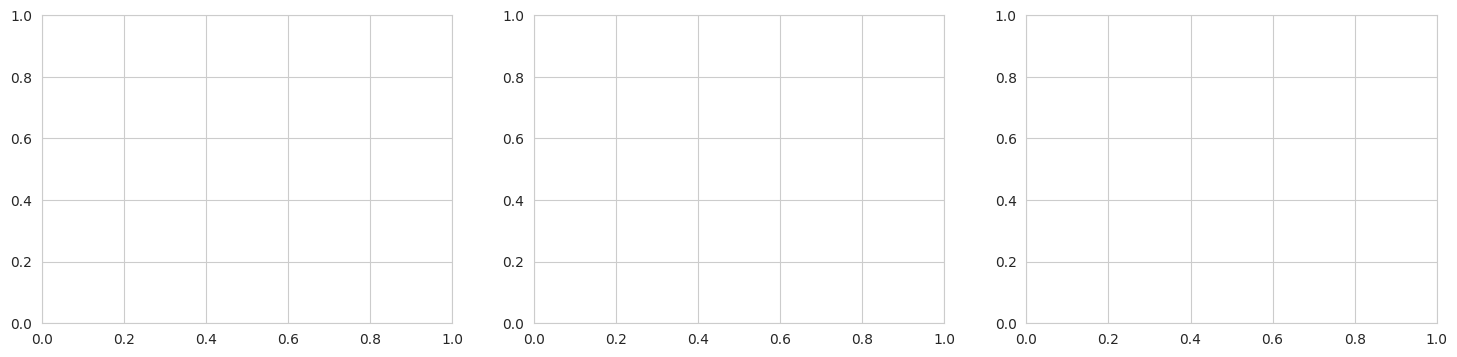

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Training loss
axes[0].plot(history['train_loss'], linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Learning rate
axes[1].plot(history['lr'], linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Epoch time
axes[2].plot(history['epoch_time'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(save_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Training curves saved to: {save_dir / 'training_curves.png'}")

## 12. Generate Multi-Scale Embeddings

In [ ]:
print("🔄 Generating multi-scale embeddings from trained encoder...\n")

# Load best model
checkpoint = torch.load(save_dir / "best_encoder.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded best model from epoch {checkpoint['epoch']}")
print(f"   Best validation loss: {checkpoint['loss']:.4f}\n")

# ============================================================================
# MODIFIÉ: Générer embeddings pour le DATASET COMPLET (train + val)
# ============================================================================

# Recréer le loader pour le dataset complet
print("📊 Creating full dataset loader...")
full_loader = DataLoader(
    dataset,  # Dataset complet (pas train_dataset/val_dataset)
    batch_size=config.batch_size,
    shuffle=False,  # Important: pas de shuffle pour traçabilité
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"   Total graphs: {len(dataset)}")
print(f"   Batches to process: {len(full_loader)}\n")

# Generate embeddings for ALL graphs
all_embeddings = {
    'assets': [],
    'zones': [],
    'regions': [],
    'nation': [],
    'metadata': [],
}

with torch.no_grad():
    for i, batch in enumerate(tqdm(full_loader, desc="Generating embeddings")):
        batch = batch.to(config.device)

        N_base = batch.N_base[0].item() if batch.N_base.dim() > 0 else batch.N_base.item()
        T = batch.T[0].item() if batch.T.dim() > 0 else batch.T.item()

        current_hierarchy = get_hierarchy_from_batch(batch, config.device)

        N_total = batch.x.size(0) if hasattr(batch, "x") and batch.x is not None else batch.num_nodes
        edge_index_with_loops, _ = add_self_loops(batch.edge_index, num_nodes=N_total)

        embeddings = model(
            batch.x,
            edge_index_with_loops,
            batch.node_type if hasattr(batch, "node_type") else None,
            N_base,
            T,
            hierarchy_mapping=current_hierarchy,
            zone_edges=None,
            region_edges=None,
            batch=None,
            return_sequence=True,
        )

        # Store embeddings (move to CPU to save GPU memory)
        all_embeddings['assets'].append(embeddings['assets'].cpu())
        all_embeddings['zones'].append(embeddings['zones'].cpu())
        all_embeddings['regions'].append(embeddings['regions'].cpu())
        all_embeddings['nation'].append(embeddings['nation'].cpu())

        # Store metadata with original dataset index
        all_embeddings['metadata'].append({
            'N_base': N_base,
            'T': T,
            'graph_idx': i,  # Index dans le dataset complet
        })

        # Libérer la mémoire GPU périodiquement
        if (i + 1) % 100 == 0:
            torch.cuda.empty_cache()

# ============================================================================
# Sauvegarder avec informations complètes
# ============================================================================

print(f"\n💾 Saving embeddings...")

# Sauvegarder les embeddings
embedding_data = {
    'embeddings': all_embeddings,
    'model_info': {
        'epoch': checkpoint['epoch'],
        'loss': checkpoint['loss'],
        'config': checkpoint['config'],
    },
    'dataset_info': {
        'total_graphs': len(dataset),
        'graph_files': [str(f) for f in graph_files],  # Traçabilité
    }
}

torch.save(embedding_data, save_dir / "embeddings_multiscale_full.pt")

print(f"\n✅ Multi-scale embeddings generated for FULL DATASET!")
print(f"  - Total graphs processed: {len(all_embeddings['assets'])}")
print(f"  - Asset-level embeddings: {len(all_embeddings['assets'])} × {all_embeddings['assets'][0].shape}")
print(f"  - Zone-level embeddings: {len(all_embeddings['zones'])} × {all_embeddings['zones'][0].shape}")
print(f"  - Region-level embeddings: {len(all_embeddings['regions'])} × {all_embeddings['regions'][0].shape}")
print(f"  - Nation-level embeddings: {len(all_embeddings['nation'])} × {all_embeddings['nation'][0].shape}")

# Calculer la taille du fichier
import os
file_size_mb = os.path.getsize(save_dir / "embeddings_multiscale_full.pt") / (1024**2)
print(f"\n💾 File size: {file_size_mb:.2f} MB")
print(f"📁 Saved to: {save_dir / 'embeddings_multiscale_full.pt'}")
print(f"\n🎯 Ready for downstream tasks: EBM, thermodynamic sampling, LP solver!")

🔄 Generating multi-scale embeddings from trained encoder...

✅ Loaded best model from epoch 101
   Best validation loss: 3.6455

📊 Creating full dataset loader...
   Total graphs: 2000
   Batches to process: 2000



/tmp/ipython-input-474886379.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_dir / "best_encoder.pt")


Generating embeddings:   0%|          | 0/2000 [00:00<?, ?it/s]


💾 Saving embeddings...

✅ Multi-scale embeddings generated for FULL DATASET!
  - Total graphs processed: 2000
  - Asset-level embeddings: 2000 × torch.Size([604, 96, 128])
  - Zone-level embeddings: 2000 × torch.Size([89, 96, 128])
  - Region-level embeddings: 2000 × torch.Size([12, 96, 128])
  - Nation-level embeddings: 2000 × torch.Size([96, 128])

💾 File size: 41552.28 MB
📁 Saved to: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_full.pt

🎯 Ready for downstream tasks: EBM, thermodynamic sampling, LP solver!


In [13]:
!ls -lh /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/

total 41G
-rw------- 1 root root 37M Dec  3 10:16 best_encoder.pt
-rw------- 1 root root 37M Dec  3 10:03 checkpoint_epoch_100.pt
-rw------- 1 root root 37M Dec  2 13:27 checkpoint_epoch_10.pt
-rw------- 1 root root 37M Dec  2 15:45 checkpoint_epoch_20.pt
-rw------- 1 root root 37M Dec  2 18:02 checkpoint_epoch_30.pt
-rw------- 1 root root 37M Dec  2 20:20 checkpoint_epoch_40.pt
-rw------- 1 root root 37M Dec  2 22:36 checkpoint_epoch_50.pt
-rw------- 1 root root 37M Dec  3 00:55 checkpoint_epoch_60.pt
-rw------- 1 root root 37M Dec  3 03:12 checkpoint_epoch_70.pt
-rw------- 1 root root 37M Dec  3 05:29 checkpoint_epoch_80.pt
-rw------- 1 root root 37M Dec  3 07:46 checkpoint_epoch_90.pt
-rw------- 1 root root 41G Dec  3 11:01 embeddings_multiscale_full.pt
